In [1]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats
from ggan import normalize, restore_scale

Using TensorFlow backend.


In [2]:
root_gene = None
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)
nb_genes = len(gene_symbols)
synthetic_name = 'EColi_n{}_r{}_e{}_d{}'.format(len(gene_symbols), root_gene, minimum_evidence, max_depth)
s_expr, s_gs = load_synthetic(synthetic_name)

assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]

# Clip outliers
r_min = np.min(expr_train)
r_max = np.max(expr_train)
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max


Found 4297 genes in datafile


In [3]:
from sklearn import preprocessing
def scale_data(data):
    return preprocessing.MinMaxScaler().fit_transform(data)

#print(scale_data(GE).max())

In [4]:
# Now import real and synthetic data from VAE
GE = np.loadtxt('./data/Zebrafish/GE_mvg.csv', delimiter = ',', dtype=np.float32)
GE_n=normalize(GE)
genes_names = np.loadtxt('./data/Zebrafish/CV_genes.csv', delimiter = '\n', dtype=bytes).astype(str)
genes_names = genes_names[1:]
genes_names = list(genes_names)

cells_names = np.loadtxt('./data/Zebrafish/Annotation_File_1.csv', delimiter = ',', dtype=str)
cells_names = list(cells_names)

#synthetic
GE_s = np.loadtxt('./data/Zebrafish/data_decoded_dis_n.csv', delimiter = ',', dtype=np.float32)
GE_s = GE_s[1:,:]
genes_names_s = genes_names

In [5]:
#print(np.amax(s_expr_restored_art))
#GE_n = normalize(GE)
#GE_s_n = normalize(GE_s)
#GE_n_data = pd.DataFrame(data=GE_n)
#GE_n_data.to_csv('./data/Zebrafish/GE_mvg_n.csv', index=False)

In [6]:
#Normalise and prepare data for analysis
r_expr = GE_n
gene_symbols = genes_names
sample_names = cells_names

nb_genes = len(gene_symbols)
s_expr = GE_s
s_gs = genes_names_s

assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Split data into train and test sets
#train_idxs, test_idxs = split_train_test(sample_names)
train_idxs=np.random.permutation(r_expr.shape[0])[:int(0.5*r_expr.shape[0])]
test_idxs=np.random.permutation(r_expr.shape[0])[int(0.5*r_expr.shape[0]):]
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]



In [7]:
print(np.random.permutation(GE.shape[0]))

[ 328  172  610 ...,  118  133 1250]


In [8]:
mean = np.mean(r_expr, axis=0)
std = np.std(r_expr, axis=0)
r_min = r_expr.min()
r_max = r_expr.max()

s_expr=normalize(s_expr)
s_expr_restored = restore_scale(s_expr, mean, std)
#s_expr_restored = s_expr*r_max

# Clip outliers
s_expr_restored[s_expr_restored < r_min] = r_min
s_expr_restored[s_expr_restored > r_max] = r_max

#s_expr_restored2 = restore_scale(s_expr, mean, std)*10
#s_expr_restored = restore_scale(s_expr, mean, std)

#s_expr_restored[s_expr_restored < r_min] = r_min
#s_expr_restored[s_expr_restored > r_max] = r_max


In [9]:
#import artificial data
GE_s_art = np.loadtxt('./data/Zebrafish/Sanger_data_decoded_artificial_N10.csv', delimiter = ',', dtype=np.float32)
GE_s_art = GE_s_art[1:,:]
genes_names_s = gene_symbols

nb_genes = len(gene_symbols)
s_expr_art = GE_s_art
s_gs = gene_symbols

assert (np.array(gene_symbols) == np.array(s_gs)).all()

s_expr_art=normalize(s_expr_art)
s_expr_restored_art = restore_scale(s_expr_art, mean, std)

# Clip outliers
r_min = np.min(expr_train)
r_max = np.max(expr_train)
s_expr_restored_art[s_expr_restored_art < r_min] = r_min
s_expr_restored_art[s_expr_restored_art > r_max] = r_max

In [10]:
#Generate random matrix to compare/validate results
random_expr = np.random.rand(GE.shape[0],GE.shape[1])

random_expr_restored = restore_scale(random_expr, mean, std)

print(random_expr_restored.shape)

(1422, 1845)


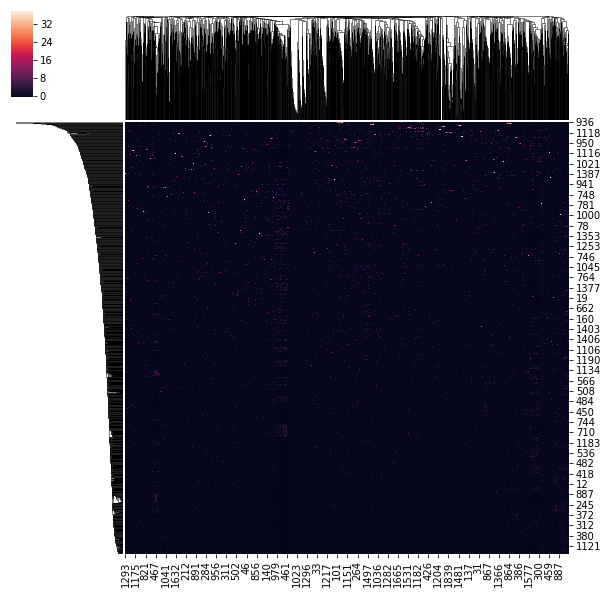

In [11]:
sns.clustermap(r_expr);
#sns.clustermap(random_expr);
plt.show()

# Intensity histograms

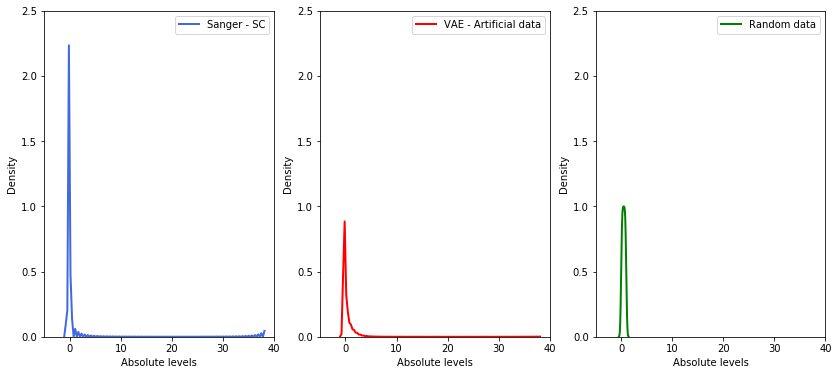

In [12]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plot_intensities(r_expr,plot_quantiles=False)
plt.ylim(0.,2.5)
plt.xlim(-5.,40)
plt.subplot(132)
plot_intensities(s_expr_restored_art, plot_quantiles=False, dataset_name='VAE - Artificial data', color='red')
plt.ylim(0.,2.5)
plt.xlim(-5.,40)
plt.subplot(133)
plot_intensities(random_expr_restored, plot_quantiles=False, dataset_name='Random data', color='green')
plt.ylim(0.,2.5)
plt.xlim(-5.,40)
plt.show()

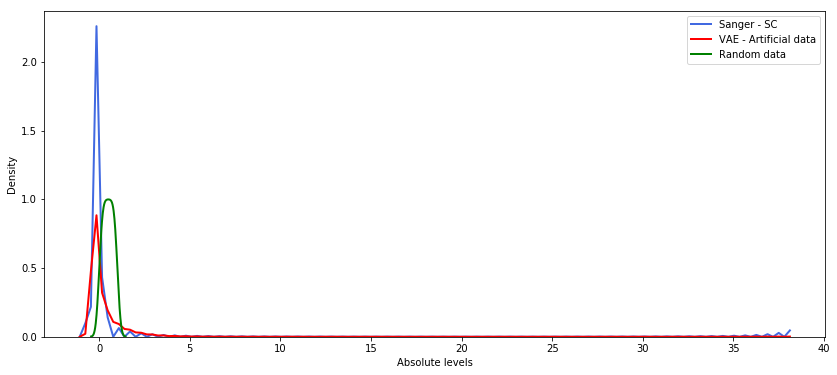

In [13]:
plt.figure(figsize=(14, 6))
ax = plot_intensities(expr_train, plot_quantiles=False)
plot_intensities(s_expr_restored_art, dataset_name='VAE - Artificial data', color='red', plot_quantiles=False, ax=ax)
plot_intensities(random_expr_restored, dataset_name='Random data', color='green', plot_quantiles=False, ax=ax)
#plt.ylim(0.,0.000001)
#plt.xlim(0.1,100000)
plt.show()

# Gene ranges histograms

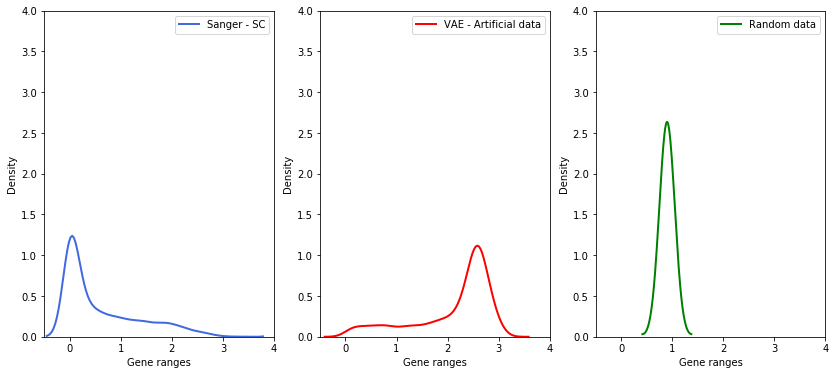

In [14]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plot_gene_ranges(r_expr)
plt.ylim(0.,4)
plt.xlim(-0.5,4)
plt.subplot(132)
plot_gene_ranges(s_expr_restored_art, dataset_name='VAE - Artificial data', color='red')
plt.ylim(0.,4)
plt.xlim(-0.5,4)
plt.subplot(133)
plot_gene_ranges(random_expr_restored, dataset_name='Random data', color='green')
plt.ylim(0.,4)
plt.xlim(-0.5,4)
#plot_gene_ranges(random_expr_restored, dataset_name='Artificial data', color='red')
plt.show()

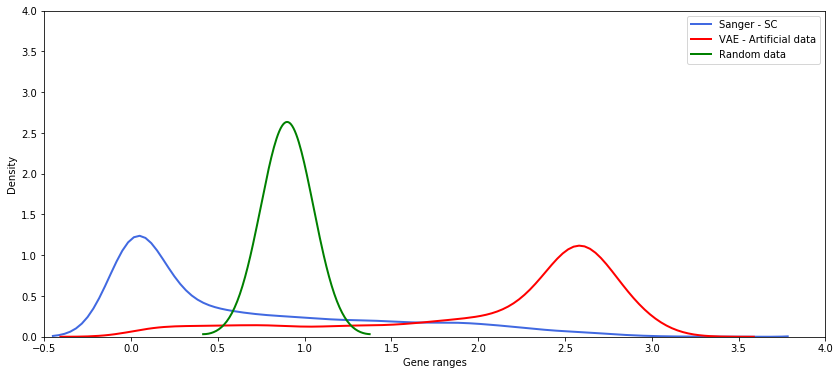

In [15]:
plt.figure(figsize=(14, 6))
ax = plot_gene_ranges(r_expr)
plot_gene_ranges(s_expr_restored_art, dataset_name='VAE - Artificial data', color='red', ax=ax)
plot_gene_ranges(random_expr_restored, dataset_name='Random data', color='green', ax=ax)
plt.ylim(0.,4)
plt.xlim(-0.5,4)
plt.show()

# Compare background distributions

In [16]:
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(r_expr, gene_symbols)
#s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(random_expr_restored, gene_symbols)
s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(s_expr_restored_art, gene_symbols)
r_back_corr = correlations_list(r_expr, r_expr)
s_back_corr = correlations_list(s_expr_restored_art, s_expr_restored_art)
rand_back_corr = correlations_list(random_expr_restored, random_expr_restored)
#s_back_corr = correlations_list(random_expr_restored, random_expr_restored)

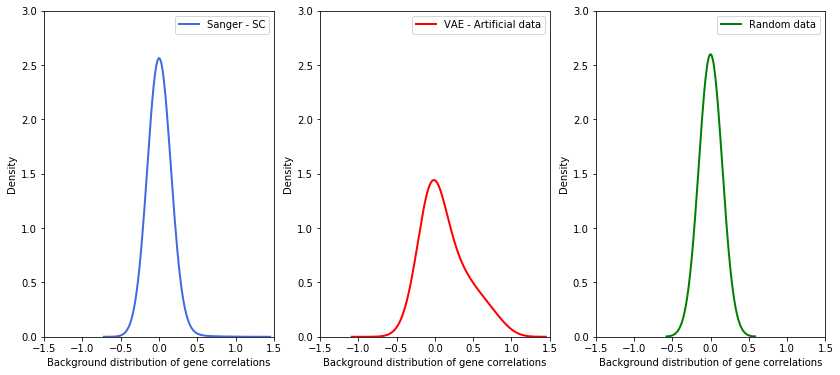

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plot_distribution(r_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density',)
plt.ylim(0.,3)
plt.xlim(-1.5,1.5)
plt.subplot(132)
plot_distribution(s_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='VAE - Artificial data', color='red')
plt.ylim(0.,3)
plt.xlim(-1.5,1.5)
plt.subplot(133)
plot_distribution(rand_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='Random data', color='green')
plt.ylim(0.,3)
plt.xlim(-1.5,1.5)
plt.show()

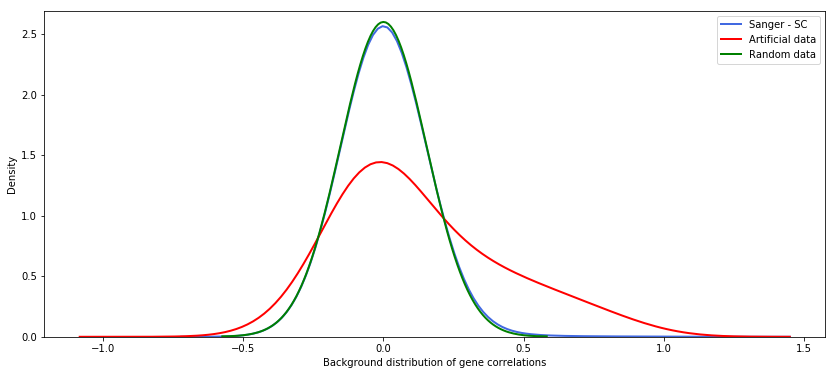

In [18]:
plt.figure(figsize=(14, 6))
ax = plot_distribution(r_back_corr, xlabel='Background distribution of gene correlations')
plot_distribution(s_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='Artificial data', color='red')
plot_distribution(rand_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='Random data', color='green')
plt.show()

# Quantitative analysis

In [20]:
print(expr_train.shape)
print(expr_test.shape)
print(s_expr.shape)

(711, 1845)
(711, 1845)
(1422, 1845)


In [21]:
scores = compute_scores_no_network(r_expr, s_expr_restored_art, gene_symbols)
#score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.4236776125895749
S_dend: 0.17308765173309282
S_sdcc: 0.07932743654041988


In [22]:
scores_boundaries = compute_scores_no_network(expr_train, expr_test, gene_symbols)
#score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores_boundaries):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.6066159418372925
S_dend: 0.16621971290840604
S_sdcc: 0.0028612321319305676


In [23]:
scores_boundaries_low = compute_scores_no_network(r_expr, random_expr_restored, gene_symbols)
#score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores_boundaries_low):
    print('{}: {}'.format(name, score))

gGAN
S_dist: -0.0014904716587348925
S_dend: -0.00023146737172547788
S_sdcc: 0.08802489532039383


# Analyze gene histograms

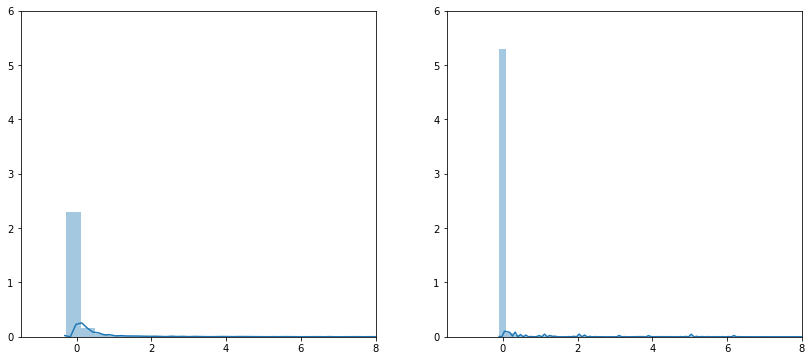

In [24]:
crp_idx = np.argwhere(np.array(gene_symbols) == '"1","ENSDARG00000076182,stat1b,9,protein_coding"')
idx = crp_idx
plt.figure(figsize=(14, 6))
plt.title('Expression levels of CRP');
plt.subplot(121)
ax = sns.distplot(s_expr_restored_art[:, idx])
plt.ylim(0.,6)
plt.xlim(-1.5,8)
plt.subplot(122)
ax = sns.distplot(expr_train[:, idx])
plt.ylim(0.,6)
plt.xlim(-1.5,8)
plt.show()

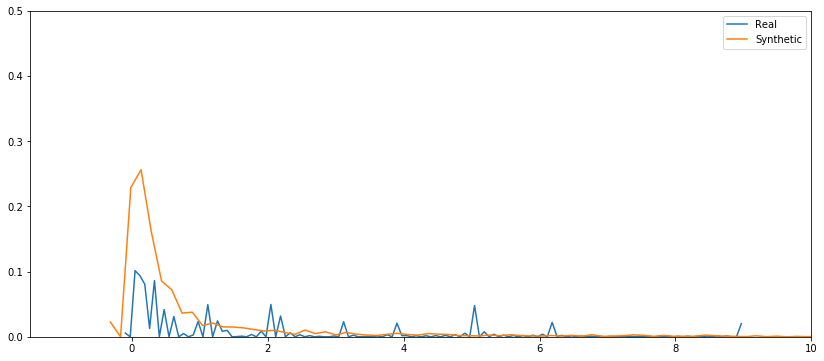

In [25]:
plt.figure(figsize=(14, 6))
r_expr_gene = expr_train[:, crp_idx]
s_expr_gene = s_expr_restored_art[:, crp_idx]
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')
plt.ylim(0.,0.5)
plt.xlim(-1.5,10)
plt.show()

In [26]:
diag = np.diag(np.ones(nb_genes))
r_corr = pearson_correlation(expr_train, expr_train) - diag
s_corr = pearson_correlation(s_expr_restored_art, s_expr_restored_art) - diag
crp_idx = np.argwhere(np.array(gene_symbols) == '"1","ENSDARG00000076182,stat1b,9,protein_coding"').ravel()

In [27]:
r_corr_crp = r_corr[crp_idx, :].ravel()
s_corr_crp = s_corr[crp_idx, :].ravel()
r_max_corr_crp = np.max(r_corr_crp)
s_max_corr_crp = np.max(s_corr_crp)
#gene with maximum correlation
sorted_idxs = np.argsort(r_corr_crp)[::-1]
print('CRP max correlated ({:.4f}) gene: {}'.format(r_max_corr_crp, gene_symbols[sorted_idxs[0]]))
print('CRP correlation with {} in synthetic: {}'.format(gene_symbols[sorted_idxs[0]], s_corr_crp[sorted_idxs[0]]))

CRP max correlated (0.4506) gene: "1512","ENSDARG00000026049,mxf,15,protein_coding"
CRP correlation with "1512","ENSDARG00000026049,mxf,15,protein_coding" in synthetic: 0.9076210260391235


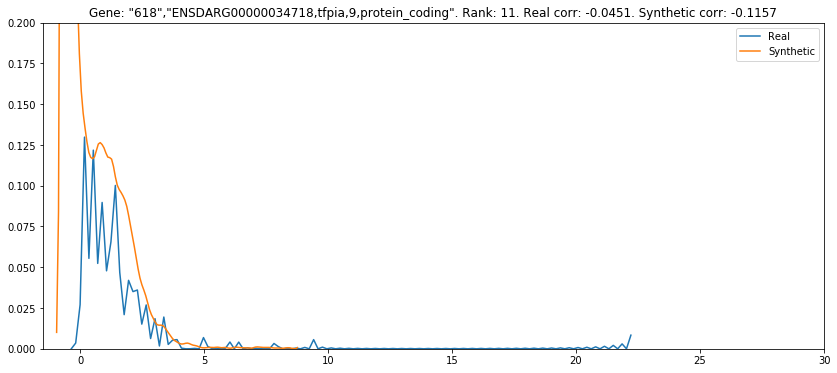

In [34]:
idx = -11
plt.figure(figsize=(14, 6))
r_expr_gene = r_expr[:, sorted_idxs[idx]]
s_expr_gene = s_expr_restored_art[:, sorted_idxs[idx]]
plt.title('Gene: {}. Rank: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[sorted_idxs[idx]],
                                                                          max(idx+1, abs(idx)),
                                                                          r_corr_crp[sorted_idxs[idx]],
                                                                          s_corr_crp[sorted_idxs[idx]]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')
plt.ylim(0.,0.2)
plt.xlim(-1.5,30)
plt.show()

# Save CSV

In [103]:
write_csv('real_SC.csv', r_expr, gene_symbols)
write_csv('synthetic_SC.csv', s_expr_restored_art, gene_symbols)